# Model Training and Evaluation Approach: 

In [13]:
!pip install mne numpy pickle5

     ---------------------------------------- 0.0/132.1 kB ? eta -:--:--
     ---------------------------------------- 132.1/132.1 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pickle5
Failed to build pickle5


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [17 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-311
  creating build\lib.win-amd64-cpython-311\pickle5
  copying pickle5\pickle.py -> build\lib.win-amd64-cpython-311\pickle5
  copying pickle5\pickletools.py -> build\lib.win-amd64-cpython-311\pickle5
  copying pickle5\__init__.py -> build\lib.win-amd64-cpython-311\pickle5
  creating build\lib.win-amd64-cpython-311\pickle5\test
  copying pickle5\test\pickletester.py -> build\lib.win-amd64-cpython-311\pickle5\test
  copying pickle5\test\test_pickle.py -> build\lib.win-amd64-cpython-311\pickle5\test
  copying pickle5\test\test_picklebuffer.py -> build\lib.win-amd64-cpython-311\pickle5\test
  copying pickle5\test\__init__.py -> build\lib.win-amd64-cpython-311\pickle5\test
  running build_ext
  building 'pickle5._pickle' extension
  error: Mi

In [14]:
import mne
import numpy as np
import pickle

def preprocess_eeg(file_path, epoch_sec=30):
    # Load the EEG data
    raw = mne.io.read_raw_edf(file_path, preload=True)
    print(f"Loaded {file_path} successfully.")
    
    # Assuming your sampling rate is constant
    sampling_rate = raw.info['sfreq']
    epoch_samples = int(epoch_sec * sampling_rate)
    
    # Segment data into epochs
    data = raw.get_data()
    total_samples = data.shape[1]
    epochs = [data[:, i:i + epoch_samples] for i in range(0, total_samples, epoch_samples) if i + epoch_samples <= total_samples]
    
    # Example: Save the first epoch to a pickle file
    with open('epoch_0.pkl', 'wb') as f:
        pickle.dump(epochs[0], f)
    print("Saved the first epoch as 'epoch_0.pkl'")

# Example usage
file_path = '102_1.edf'  
preprocess_eeg(file_path, epoch_sec=30)


Extracting EDF parameters from C:\Users\bu23957\Downloads\102_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12316999  =      0.000 ... 24633.998 secs...


C:\Users\bu23957\AppData\Local\Temp\ipykernel_17156\3669998244.py:7: RuntimeWarning: Omitted 16 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)
C:\Users\bu23957\AppData\Local\Temp\ipykernel_17156\3669998244.py:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file_path, preload=True)


Loaded 102_1.edf successfully.
Saved the first epoch as 'epoch_0.pkl'


In [15]:
import pickle

# Load the saved epoch
with open('epoch_0.pkl', 'rb') as f:
    epoch = pickle.load(f)

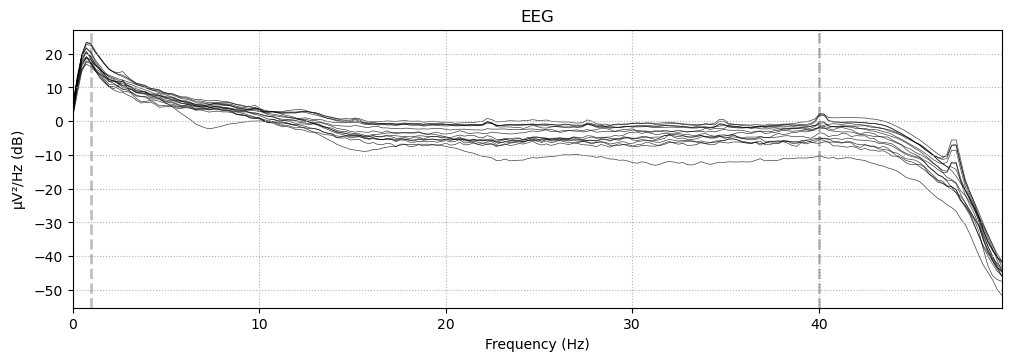

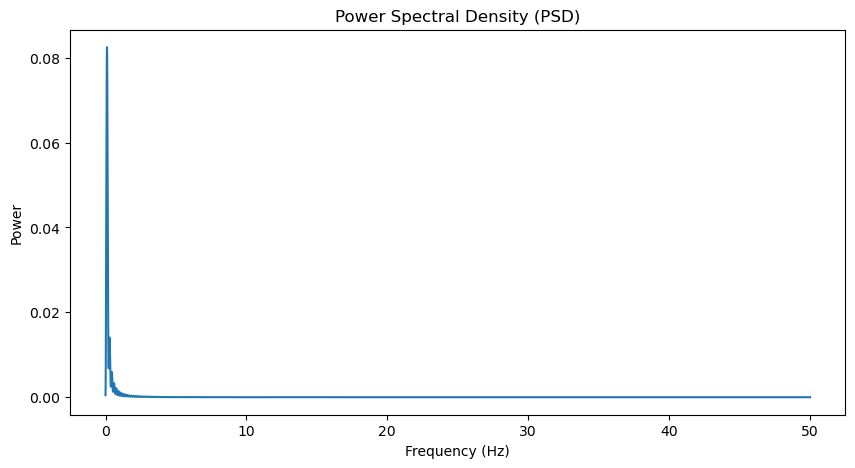

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Assume your sampling rate was 100 Hz, adjust as per your dataset
sampling_rate = 100

# Calculate the Power Spectral Density (PSD)
freqs = np.fft.rfftfreq(epoch.shape[1], 1/sampling_rate)
psd = np.abs(np.fft.rfft(epoch, axis=1))**2

# Average PSD across channels (if your epoch has multiple channels)
avg_psd = np.mean(psd, axis=0)

# Plot the PSD
plt.figure(figsize=(10, 5))
plt.plot(freqs, avg_psd)
plt.title('Power Spectral Density (PSD)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

In [18]:
def bandpower(data, sf, band, method='welch', axis=-1):
    from scipy.signal import welch
    band = np.asarray(band)
    low, high = band

    # Use Welch's method to compute the PSD and then sum over the specified frequency band
    freqs, psd = welch(data, sf, axis=axis)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.sum(psd[:, idx_band], axis=-1)

# Define frequency bands
bands = {'Delta': (0.5, 4),
         'Theta': (4, 8),
         'Alpha': (8, 12),
         'Beta': (12, 30)}

features = {band: bandpower(epoch, sampling_rate, bands[band]) for band in bands}

print("Extracted Features:", features)


Extracted Features: {'Delta': array([2.89010877e-10, 7.24113221e-11, 8.88398599e-09, 9.91902931e-09,
       2.96071188e-10, 9.82435161e-09, 8.55934593e-09, 2.93987127e-10,
       9.96401135e-09, 9.11474478e-09, 6.82880889e-11, 8.55037765e-09,
       9.95182390e-09, 9.22573713e-09, 1.01692557e-08]), 'Theta': array([2.60800412e-11, 3.27922823e-11, 6.03776617e-10, 6.67817283e-10,
       2.17494938e-11, 6.77453859e-10, 5.73601305e-10, 2.11248625e-11,
       6.76211190e-10, 6.18023164e-10, 3.02565172e-11, 5.77862499e-10,
       6.70170487e-10, 6.09804311e-10, 6.89571552e-10]), 'Alpha': array([3.41065615e-11, 8.51197064e-12, 1.46969052e-10, 1.65962376e-10,
       6.08866271e-12, 1.95919780e-10, 1.43825270e-10, 1.09383617e-11,
       1.69383144e-10, 1.56780005e-10, 1.02292669e-11, 1.53315590e-10,
       1.87102942e-10, 1.61730809e-10, 1.95781470e-10]), 'Beta': array([1.92257742e-11, 3.44140757e-11, 2.50212535e-10, 2.77588959e-10,
       8.12582043e-12, 2.73593127e-10, 2.37235296e-10, 2.506472

In [20]:
import pandas as pd

# Correctly loading the CSV data into a DataFrame
loaded_df = pd.read_csv('eeg_features.csv')

# Now `loaded_df` contains your dataset ready for machine learning
print(loaded_df)

           Delta         Theta         Alpha          Beta  label
0   2.890109e-10  2.608004e-11  3.410656e-11  1.922577e-11      0
1   7.241132e-11  3.279228e-11  8.511971e-12  3.441408e-11      0
2   8.883986e-09  6.037766e-10  1.469691e-10  2.502125e-10      0
3   9.919029e-09  6.678173e-10  1.659624e-10  2.775890e-10      0
4   2.960712e-10  2.174949e-11  6.088663e-12  8.125820e-12      0
5   9.824352e-09  6.774539e-10  1.959198e-10  2.735931e-10      0
6   8.559346e-09  5.736013e-10  1.438253e-10  2.372353e-10      0
7   2.939871e-10  2.112486e-11  1.093836e-11  2.506472e-11      0
8   9.964011e-09  6.762112e-10  1.693831e-10  2.748541e-10      0
9   9.114745e-09  6.180232e-10  1.567800e-10  2.516217e-10      0
10  6.828809e-11  3.025652e-11  1.022927e-11  4.041540e-11      0
11  8.550378e-09  5.778625e-10  1.533156e-10  2.391171e-10      0
12  9.951824e-09  6.701705e-10  1.871029e-10  2.711519e-10      0
13  9.225737e-09  6.098043e-10  1.617308e-10  2.567078e-10      0
14  1.0169

# EDA

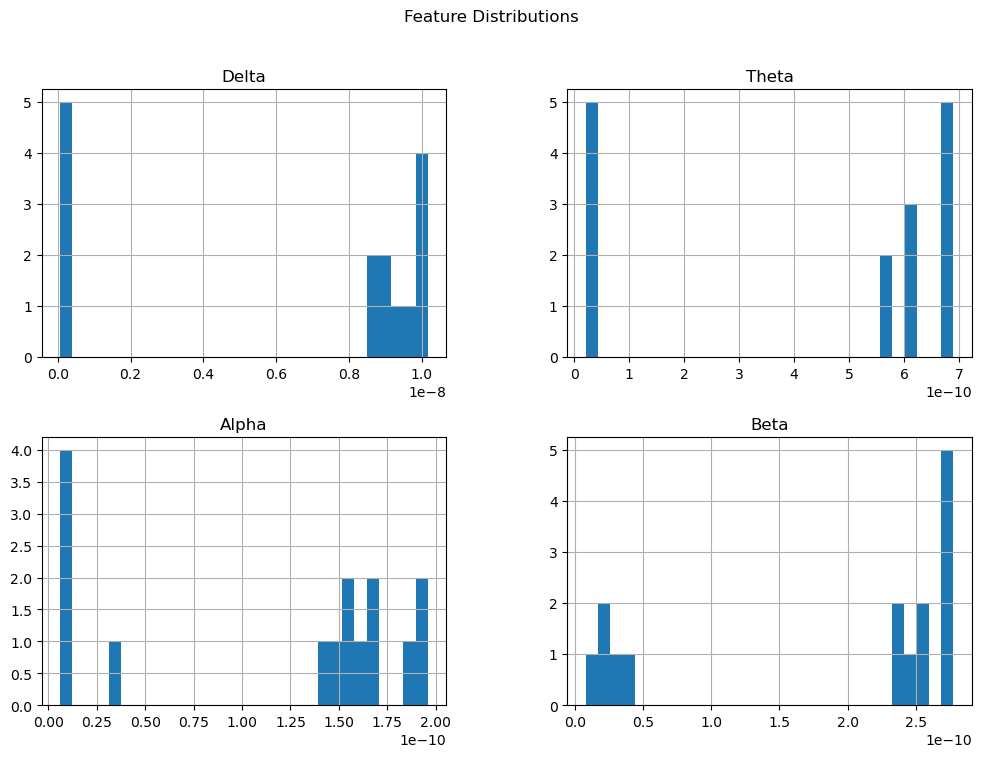

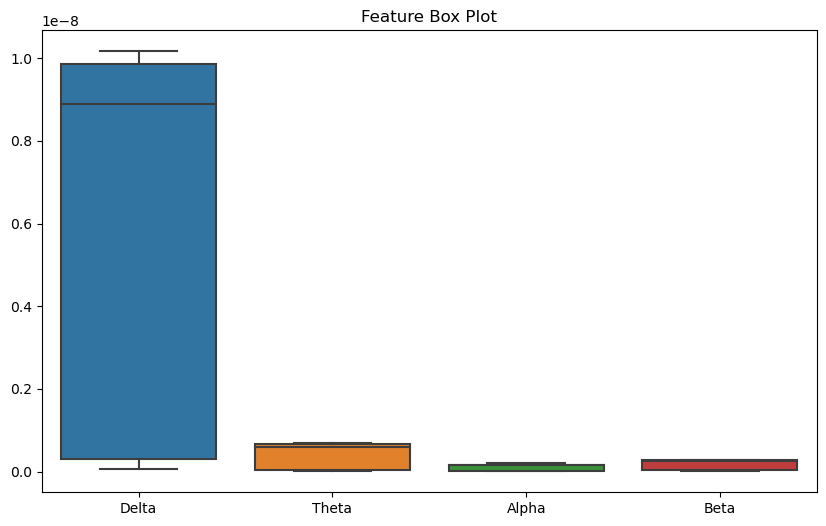

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distributions of features
loaded_df.drop('label', axis=1).hist(bins=30, figsize=(12, 8))
plt.suptitle('Feature Distributions')
plt.show()

# Boxplot to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=loaded_df.drop('label', axis=1))
plt.title('Feature Box Plot')
plt.show()

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(loaded_df.drop('label', axis=1))

# If you want to convert back to a DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=loaded_df.columns[:-1])
scaled_df['label'] = loaded_df['label']

In [23]:
from sklearn.model_selection import train_test_split

X = scaled_df.drop('label', axis=1)
y = scaled_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Mock data creation for demonstration (replace with your actual data)
# This is just to ensure the code runs without needing the actual EEG data.
np.random.seed(42)  # For reproducible results
data = np.random.rand(100, 4)  # 100 samples, 4 features
labels = np.random.randint(0, 2, 100)  # Binary labels; replace with your actual labels

# Convert to DataFrame
df = pd.DataFrame(data, columns=['Delta', 'Theta', 'Alpha', 'Beta'])
df['label'] = labels

# Splitting data into features (X) and labels (y)
X = df.drop('label', axis=1)
y = df['label']

# Stratified split to ensure class distribution is maintained
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check if the training data has at least two classes
unique_classes = np.unique(y_train)
if len(unique_classes) > 1:
    # Train the logistic regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model accuracy: {accuracy:.2f}")
else:
    print("Training halted: Not enough classes for logistic regression. Found classes:", unique_classes)

Model accuracy: 0.50
